In [1]:
# -*- coding: utf-8 -*-
#without truncating sequence length
import pickle
from torch.autograd import Variable
import numpy as np
import torch
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import random

In [15]:
torch.random.manual_seed(100)
np.random.seed(100)
#load data
pickle_path = "../pickles/"
strath_preproc_data = pickle.load( open( pickle_path+"strath_preproc_data.p", "rb" ) )

features_data = pickle.load( open( pickle_path+"strath_preproc_data.p", "rb" ) )
features_data.p

In [21]:
strath_preproc_data.shape

(80, 334)

In [2]:

#select one target output column 
target_output_column = 0
X_data = strath_preproc_data.ix[:,:-16]
Y_data = strath_preproc_data['output_'+str(target_output_column)]

#define model
class Neural(torch.nn.Module):
    def __init__(self):
        super(Neural,self).__init__()

        self.fc1 = torch.nn.Linear(318,150)
        self.fc2 = torch.nn.Linear(150,50)
        self.fc3 = torch.nn.Linear(50,1)
        dropout_p = 0.2
        self.dropout_layer = torch.nn.Dropout(p=dropout_p)
    def forward(self,x):
        x_temp = self.fc1(self.dropout_layer(x))
        x_temp = self.fc2(self.dropout_layer(x_temp))
        x_temp = self.fc3(self.dropout_layer(x_temp))
        
        return x_temp

def predict(regression_model, x_test_tensor,num_samples=20):
    y_preds_list = [regression_model(x_test_tensor).cpu().detach().numpy().reshape(-1) for i in range(num_samples)]
    y_preds_np = np.array(y_preds_list)
    y_pred_mean=np.mean(y_preds_np,axis=0)
    y_pred_std=np.std(y_preds_np,axis=0)
    
    return (y_preds_np,y_pred_mean,y_pred_std)   

regression_model = Neural()
scaler = StandardScaler()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(regression_model.parameters(), lr= 0.0001)

kf = KFold(n_splits=5)
y_pred_kfold =[]
y_pred_mean_kfold =[]
y_pred_std_kfold =[]

mse_kfold=[]

#input data settings 
drop_index_23k = False
drop_anomaly = True
randomShuffling= True

index_23k = [ 0, 21, 42, 52, 55, 59, 60, 64, 69, 70, 74, 76]

if(drop_index_23k == True):
    Y_data=Y_data.drop(index_23k)
    X_data=X_data.drop(index_23k)

elif(drop_anomaly == True):
    Y_data=Y_data.drop([0,69])
    X_data=X_data.drop([0,69])

#randomShuffling
if(randomShuffling == True):
    index_list = X_data.index.tolist()
    random.shuffle(index_list)
    Y_data=Y_data.loc[index_list]
    X_data=X_data.loc[index_list]

#reset index
Y_data= Y_data.reset_index(drop=True)
X_data= X_data.reset_index(drop=True)

y_actual=Y_data.values


C:\Users\Administrator\Downloads\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [3]:
print(Y_data.shape)

(78,)


In [4]:
print(X_data.shape)

(78, 318)


In [5]:
num_samples = 30
for train, test in kf.split(X_data,y=Y_data):
    #print("%s %s" % (train, test))
    #test=np.array([x for x in test if x not in index_23k] )
    #train=np.array([x for x in train if x not in index_23k])
    regression_model = Neural()
    scaler = StandardScaler()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(regression_model.parameters(), lr= 0.0001)

    x_train=X_data.iloc[train]
    y_train=Y_data.iloc[train]
    x_test=X_data.iloc[test]
    y_test=Y_data.iloc[test]
    
    #preprocess
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    x_test=scaler.transform(x_test)

    x_train_tensor = Variable(torch.from_numpy(x_train).float())
    y_train_tensor = Variable(torch.from_numpy(y_train.values).float())
    x_test_tensor = Variable(torch.from_numpy(x_test).float())
    y_test_tensor = Variable(torch.from_numpy(y_test.values).float())
    
    #training
    num_epochs = 1000
    for epoch in range(num_epochs):
        y_pred = regression_model(x_train_tensor).view(-1)
        loss = criterion(y_pred,y_train_tensor)    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print("LOSS: {}".format(loss.item()))
    y_preds_np,y_pred_mean,y_pred_std = predict(regression_model, x_test_tensor,num_samples=num_samples)
    #testing
    #y_pred_test = regression_model(x_test_tensor)
    y_pred_kfold = y_pred_kfold+y_preds_np.transpose(1,0).tolist()
    mse = mean_squared_error(y_test_tensor,y_pred_mean)
    y_pred_mean_kfold.append(y_pred_mean)
    y_pred_std_kfold.append(y_pred_std)
    
    mse_kfold.append(mse)
#y_pred_kfold.reverse()
y_pred_mean_kfold_np=[]
for k in range(len(y_pred_mean_kfold)):
    for i in range(y_pred_mean_kfold[k].shape[0]):
        y_pred_mean_kfold_np.append(y_pred_mean_kfold[k][i])
y_pred_mean_kfold_np = np.array(y_pred_mean_kfold_np)        

y_pred_kfold_std_np=[]
for k in range(len(y_pred_std_kfold)):
    for i in range(y_pred_std_kfold[k].shape[0]):
        y_pred_kfold_std_np.append(y_pred_std_kfold[k][i])
y_pred_kfold_std_np = np.array(y_pred_kfold_std_np)  

    
mse_mean =np.mean(np.array(mse_kfold))
mse_std =np.std(np.array(mse_kfold))

In [6]:
#raw results of predictions 
from pprint import pprint
print(len(y_pred_kfold))
print(len(y_pred_kfold[0]))
pprint(y_pred_kfold)

78
30
[[0.01740727573633194,
  0.016914768144488335,
  -0.031872957944869995,
  0.0432334840297699,
  0.02230112999677658,
  0.10385110229253769,
  0.013345060870051384,
  -0.008069448173046112,
  0.02696063369512558,
  -0.05512627959251404,
  0.06196897104382515,
  -0.07654132694005966,
  0.05547654628753662,
  0.0030455291271209717,
  6.563588976860046e-05,
  0.0783141478896141,
  0.023742303252220154,
  -0.04126197099685669,
  0.04257955402135849,
  -0.02638508379459381,
  0.06162171810865402,
  -0.008538477122783661,
  0.016131408512592316,
  0.02350183203816414,
  0.008634857833385468,
  -0.03137537091970444,
  -0.03904455155134201,
  0.009571880102157593,
  0.10915259271860123,
  0.018875781446695328],
 [-0.03076009452342987,
  -0.05125703662633896,
  0.03107535094022751,
  -0.09982260316610336,
  -0.06277298182249069,
  -0.06451603025197983,
  -0.01576506346464157,
  0.041616205126047134,
  0.018920546397566795,
  -0.0643654391169548,
  0.05032838508486748,
  0.00685549154877662

In [7]:
print(y_pred_mean_kfold_np)
y_pred_mean_kfold_np.shape

[ 0.01461602 -0.009008    0.04685498  0.01843321  0.00398776  0.06451927
  0.01004455 -0.0237732  -0.02811839 -0.00647372 -0.00827652  0.08668587
  0.00629063  0.01785504 -0.01865593  0.0003541   0.04068271 -0.01258907
  0.0040141   0.03196879 -0.00318505 -0.00039257  0.01344778  0.05333829
 -0.02056492  0.00073309 -0.0165397  -0.02445894 -0.01807492  0.02822001
  0.02799556  0.00978043  0.03800093  0.00014992 -0.00772819  0.0229716
  0.02080056  0.01105121 -0.01988121  0.04646286 -0.00355526  0.0068814
  0.05404996  0.0074632   0.03335829 -0.00812015 -0.01464894  0.00129583
  0.01928089  0.03888565  0.01511812 -0.0274185  -0.01158203  0.00772583
  0.01371686  0.00718461 -0.03763442  0.03113518 -0.00857676  0.01775749
 -0.00656487 -0.00954325  0.05285188 -0.00595159 -0.00340407  0.02652206
  0.00132507  0.02933161  0.04791864  0.04887478 -0.0113124   0.01372164
 -0.02962553  0.00644282  0.02774425 -0.00148694  0.00588569  0.04825159]


(78,)

In [8]:
print(y_pred_kfold_std_np)
y_pred_kfold_std_np.shape

[0.04308102 0.04568635 0.08823584 0.04001983 0.04272569 0.04693744
 0.03377683 0.03501637 0.07785659 0.03507498 0.03506822 0.05922756
 0.05474922 0.0531478  0.03596777 0.07209014 0.10609494 0.050349
 0.04617423 0.03282135 0.04342723 0.04018636 0.03878792 0.05254649
 0.0393663  0.03485585 0.03287857 0.04505732 0.03781751 0.03833094
 0.04721504 0.03273157 0.04191206 0.03269435 0.03233491 0.0328492
 0.04823929 0.04125057 0.04763316 0.05868385 0.03421393 0.02750749
 0.08057739 0.04225702 0.08916312 0.03626625 0.03426296 0.04153102
 0.03633859 0.02959074 0.05762763 0.03711998 0.04670518 0.03132918
 0.03835474 0.04188279 0.03885705 0.08318946 0.04980651 0.09127091
 0.05415479 0.03583572 0.06412551 0.05130177 0.04584788 0.04762236
 0.04797892 0.04922919 0.06102406 0.06716661 0.05700903 0.05017402
 0.08728587 0.13219912 0.04149681 0.05724677 0.0579456  0.06557757]


(78,)

In [9]:
#MSE of kfold

mse_mean =np.mean(np.array(mse_kfold))
mse_std =np.std(np.array(mse_kfold))

print("MSE MEAN: "+str(mse_mean)+"+-"+str(mse_std))
print(mse_kfold)

MSE MEAN: 0.00044668006+-0.00012795487
[0.0005515462, 0.00042134753, 0.00057495263, 0.0004696194, 0.00021593446]


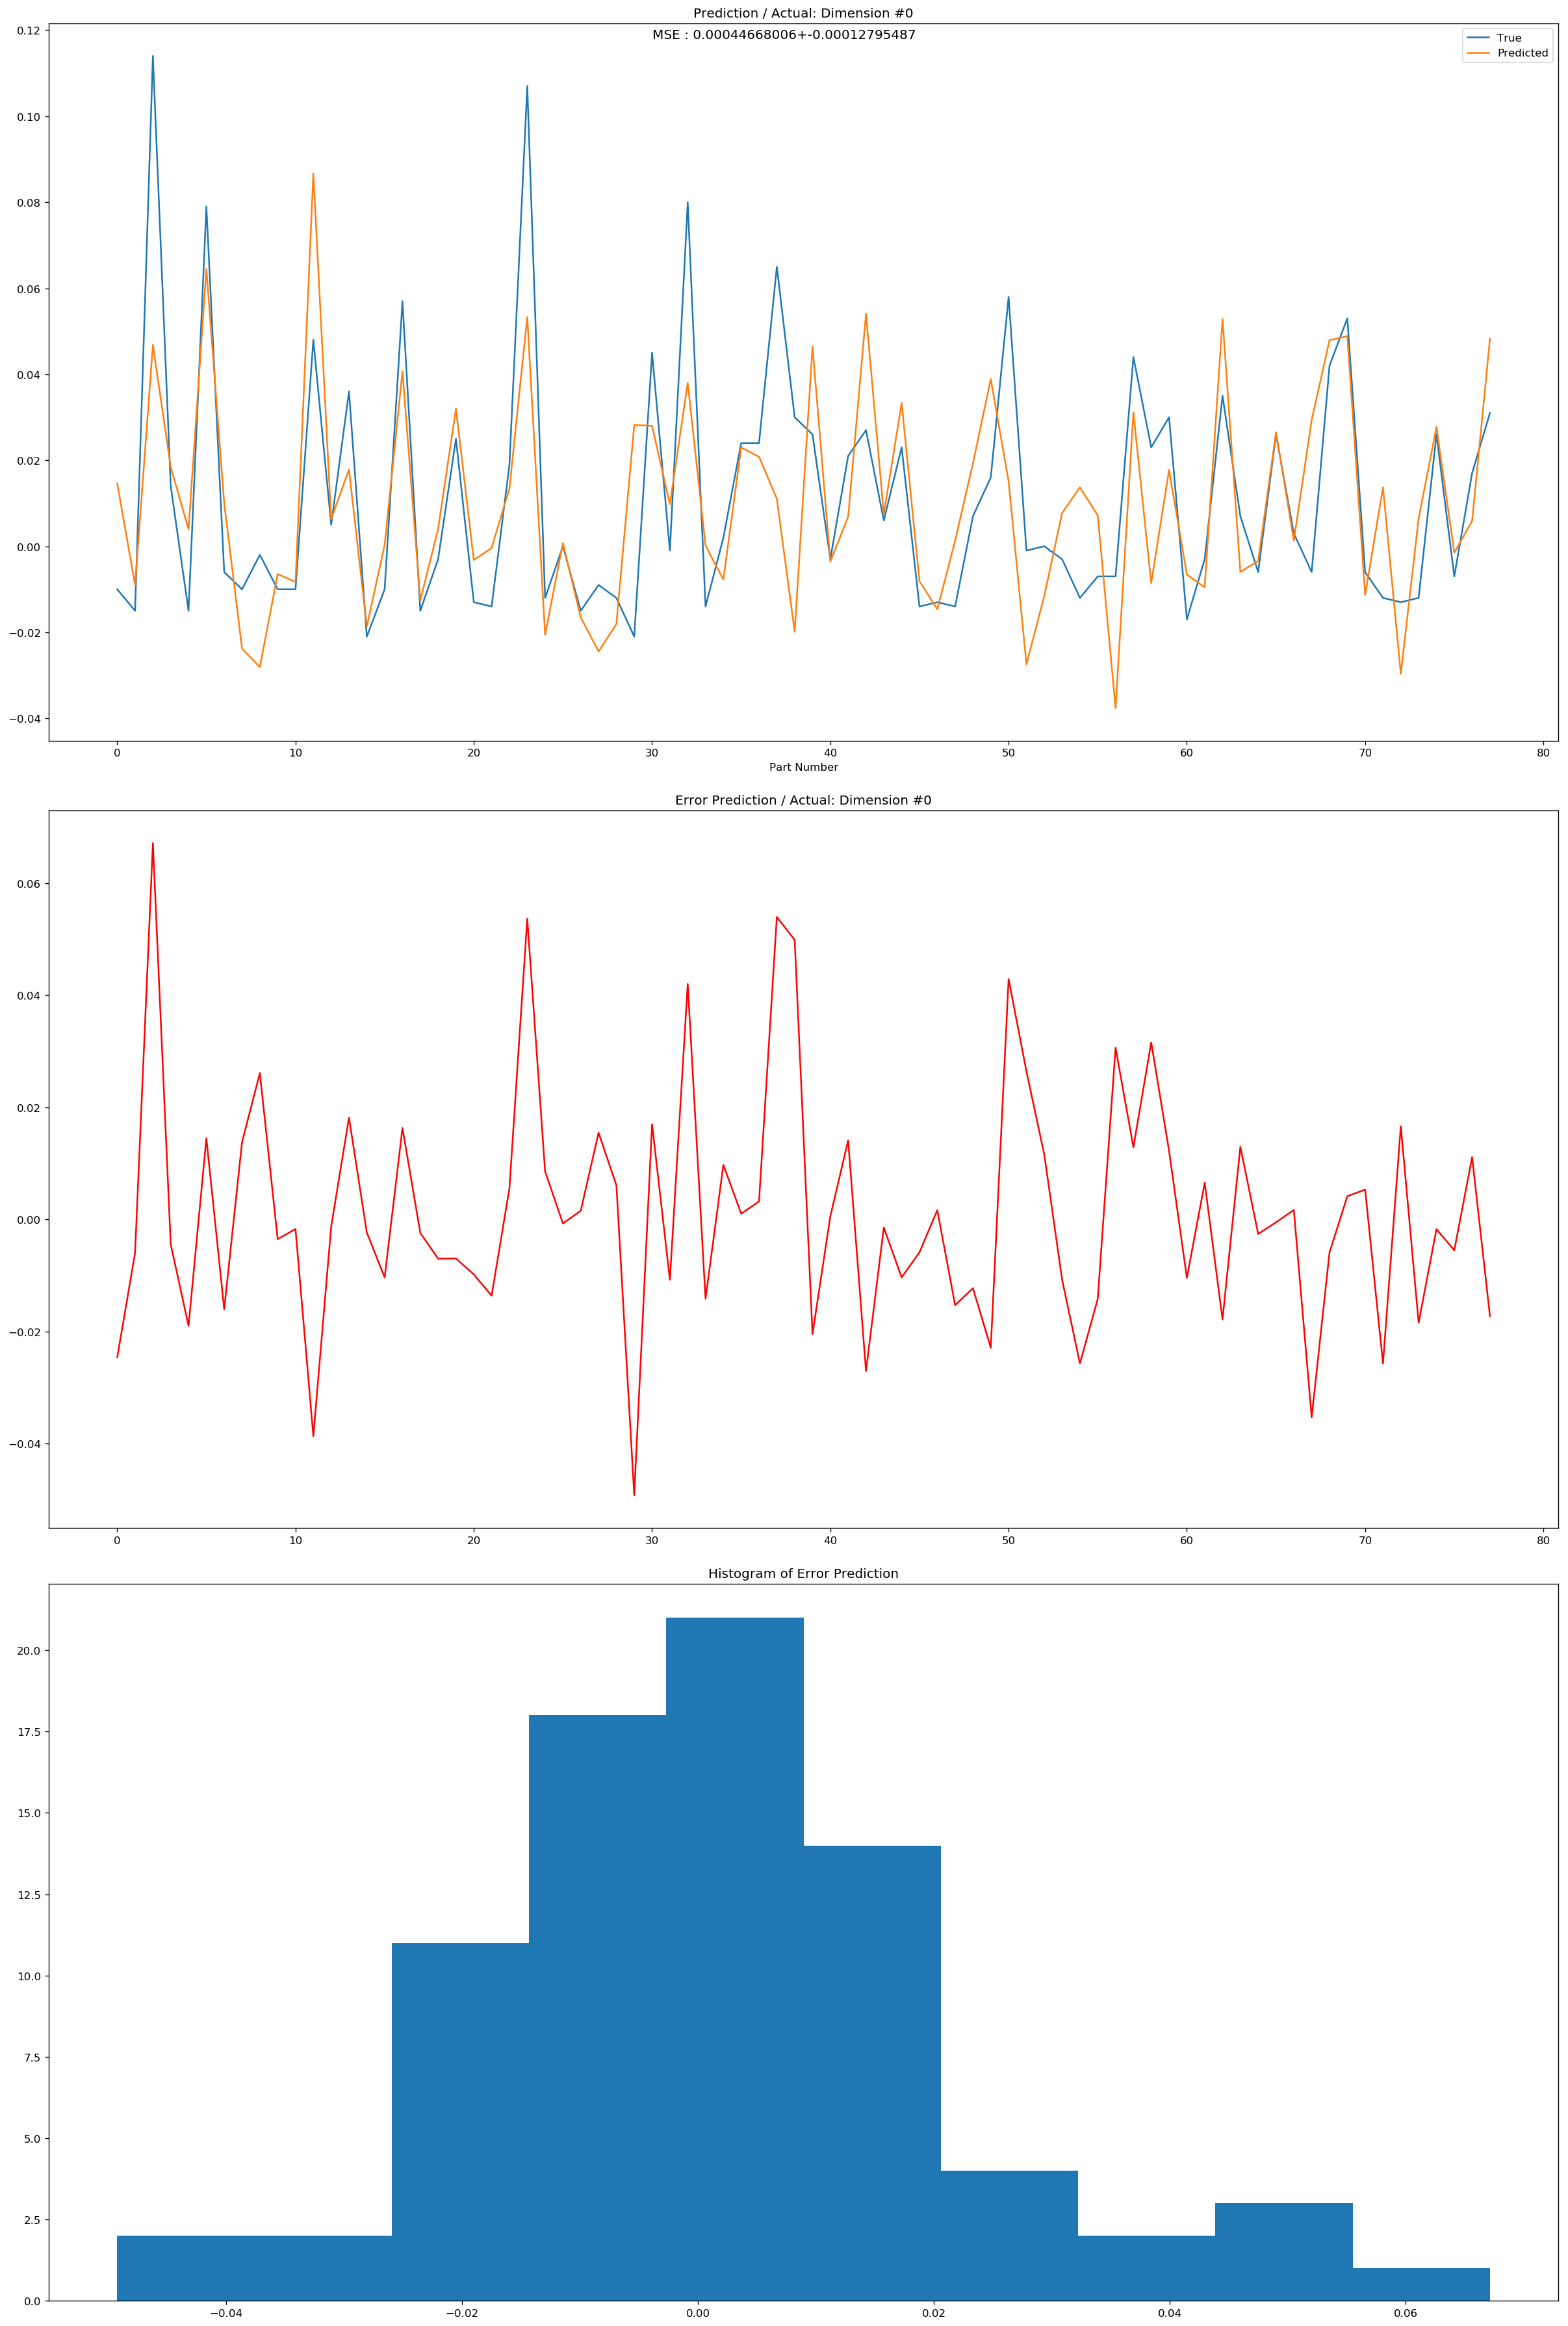

<Figure size 432x288 with 0 Axes>

In [10]:
error = y_actual-y_pred_mean_kfold_np

fig, (ax1, ax2,ax3) = plt.subplots(3, 1, constrained_layout=True,dpi=120,figsize=(20,30))
ax1.plot(Y_data.values)
ax1.plot(y_pred_mean_kfold_np)
ax1.legend(['True','Predicted'])
ax1.set_xlabel("Part Number")
ax1.set_title("Prediction / Actual: Dimension #"+str(target_output_column))
ax2.plot(error,color='r')
ax2.set_title("Error Prediction / Actual: Dimension #"+str(target_output_column))
ax3.hist(error)
ax3.set_title("Histogram of Error Prediction")
fig.suptitle("MSE : "+str(mse_mean)+"+-"+str(mse_std))       
plt.show()
plt.clf()

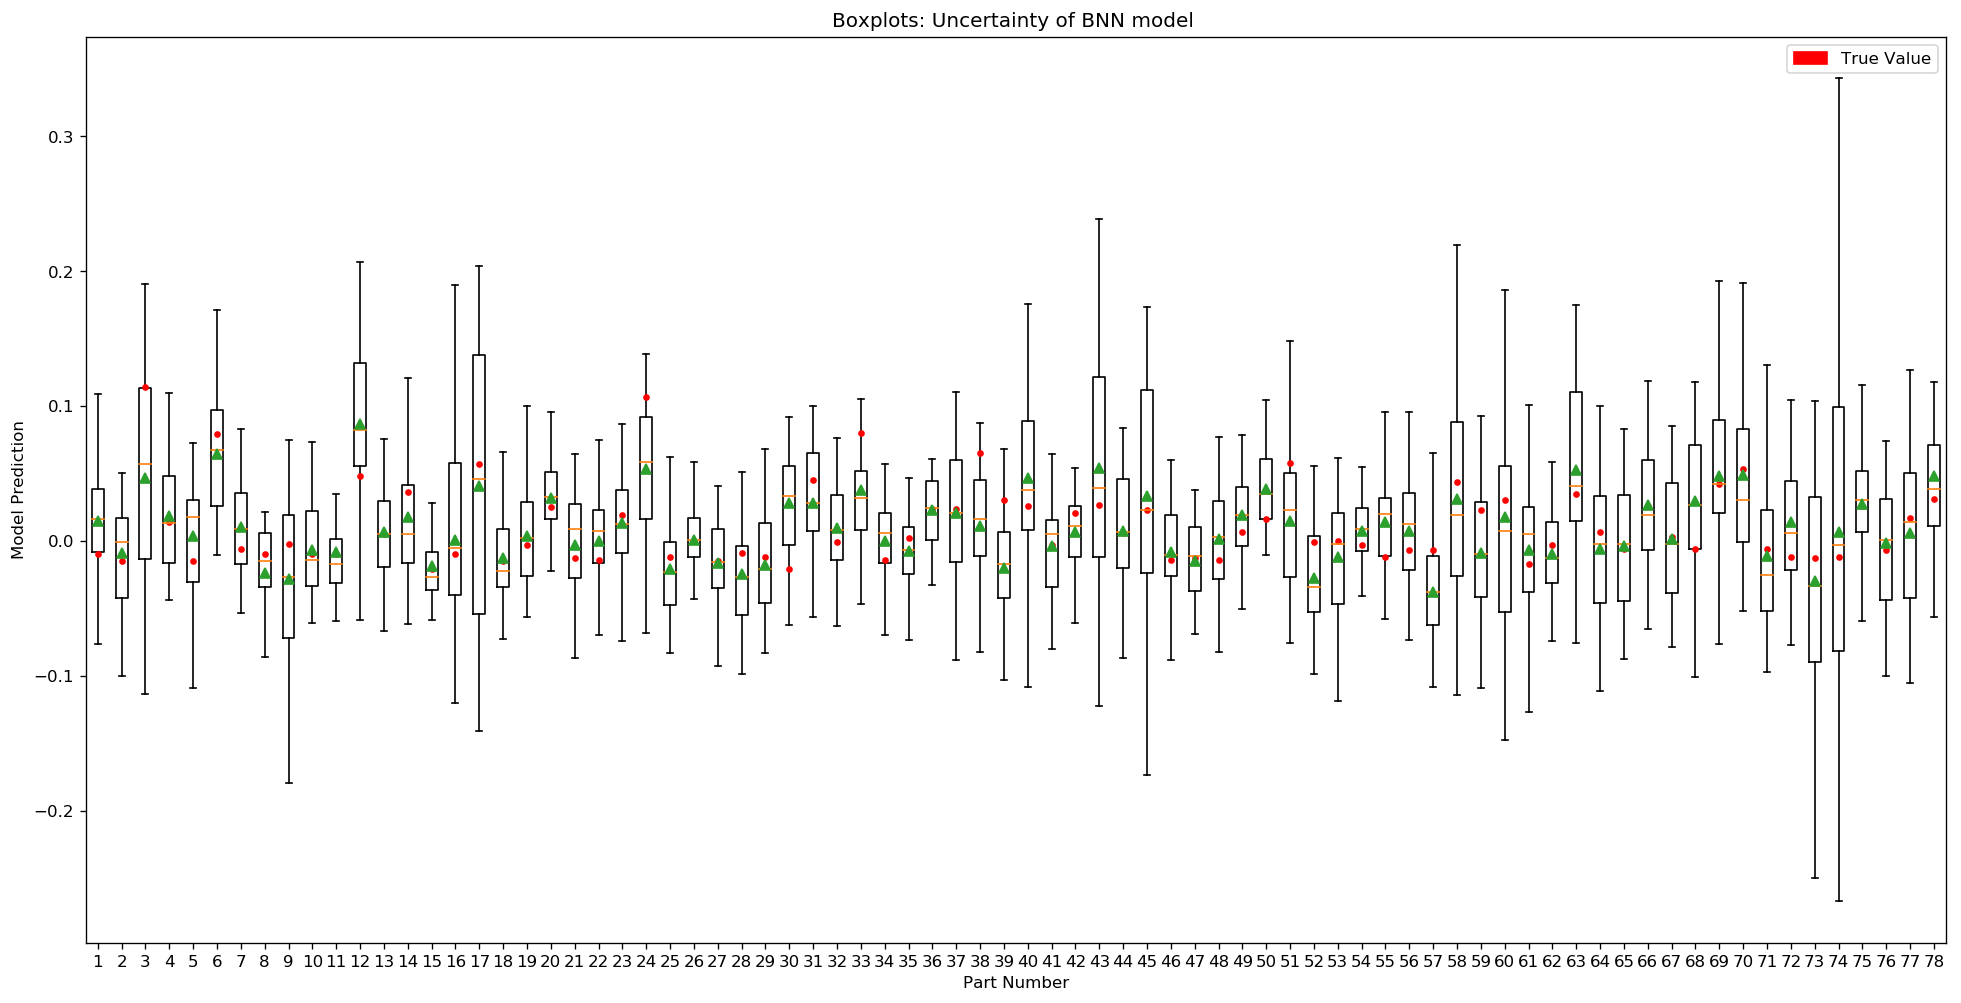

<Figure size 432x288 with 0 Axes>

In [11]:
#box plot
# Create a figure instance
fig = plt.figure(2,dpi=120,figsize=(20,10))
ax = fig.add_subplot(111)
ax.boxplot(y_pred_kfold,showmeans=True, showfliers=False)
ax.plot(np.arange(1,len(y_actual)+1),y_actual,'r.')
red_patch = mpatches.Patch(color='red', label='True Value')
ax.legend(handles=[red_patch])
plt.title("Boxplots: Uncertainty of BNN model ")
plt.ylabel("Model Prediction")
plt.xlabel("Part Number")
plt.show()
plt.clf()

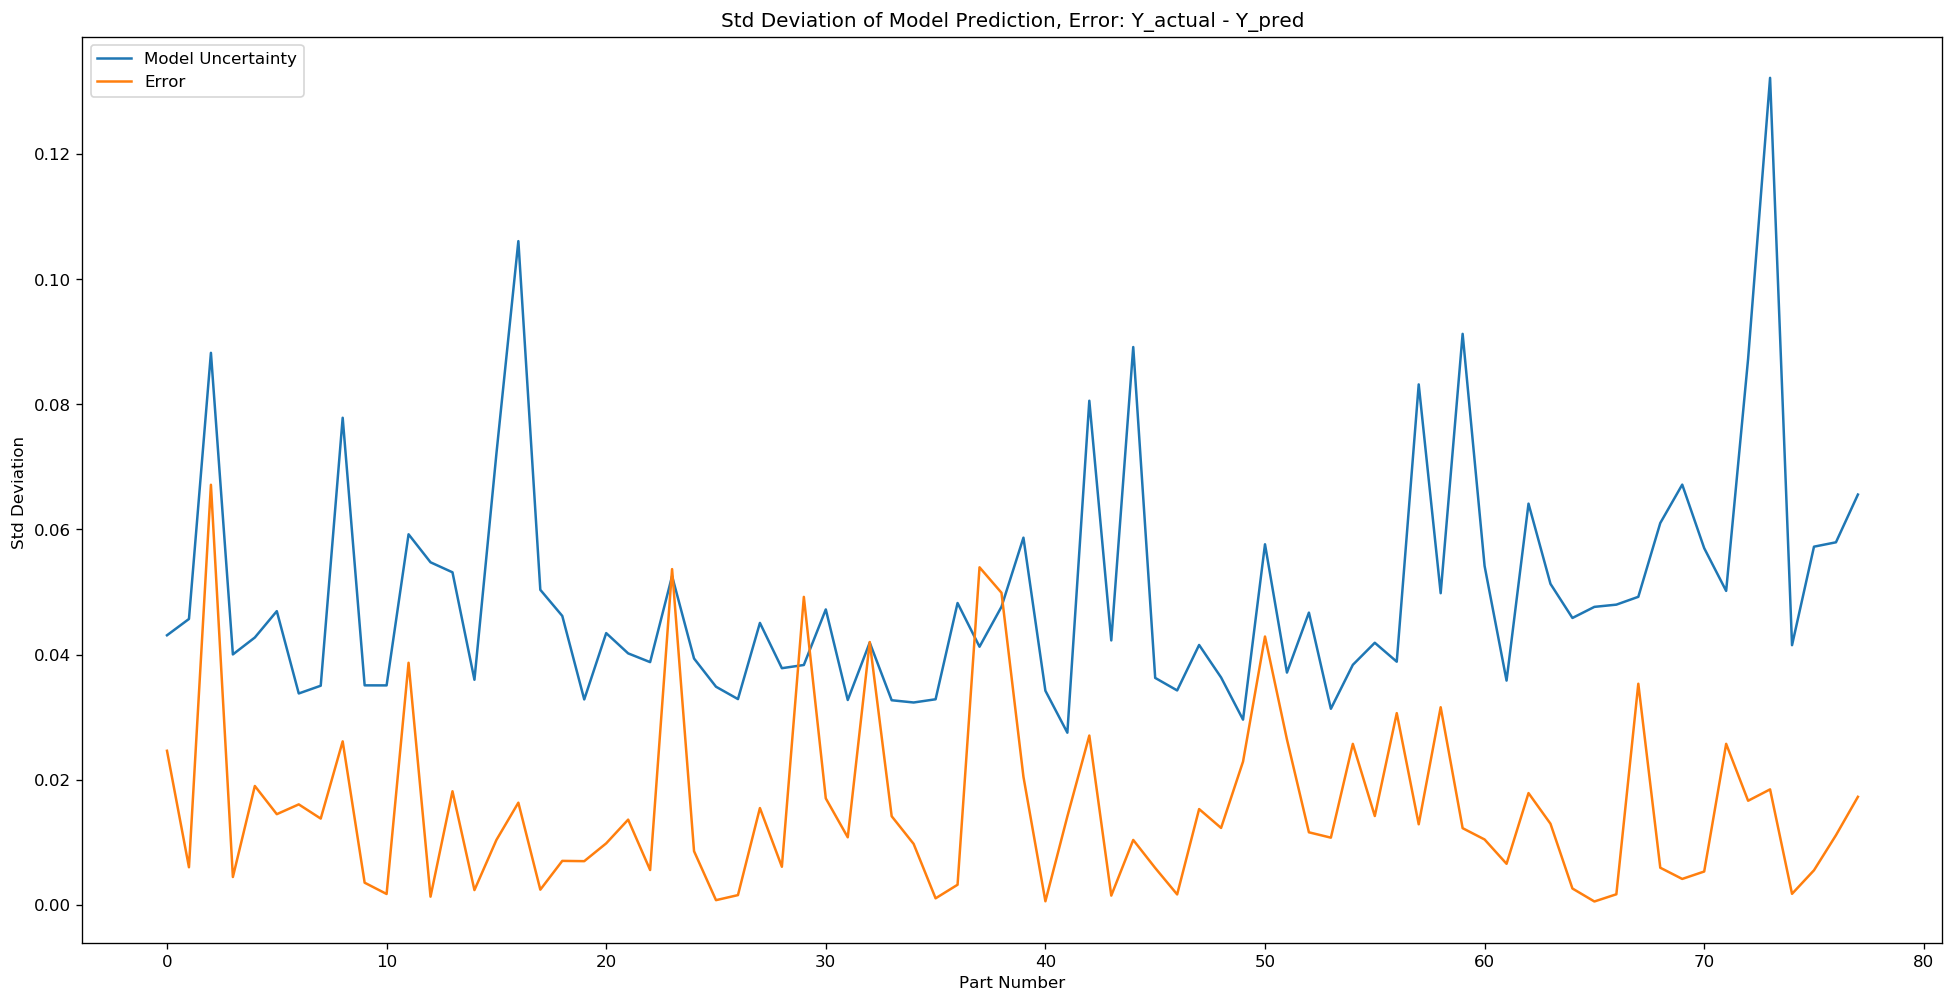

<Figure size 432x288 with 0 Axes>

In [12]:
#error vs uncertainty of model prediction
error_v1 = np.abs(y_actual-y_pred_mean_kfold_np)
y_pred_kfold_std_np_abs = np.abs(y_pred_kfold_std_np)

fig = plt.figure(2,dpi=120,figsize=(20,10))
#error_v1 = y_actual-y_pred_mean_kfold_np
plt.plot(y_pred_kfold_std_np_abs)
plt.plot(error_v1)
plt.title("Std Deviation of Model Prediction, Error: Y_actual - Y_pred")
plt.ylabel("Std Deviation ")
plt.xlabel("Part Number")
plt.legend(["Model Uncertainty","Error"])
plt.show()
plt.clf()

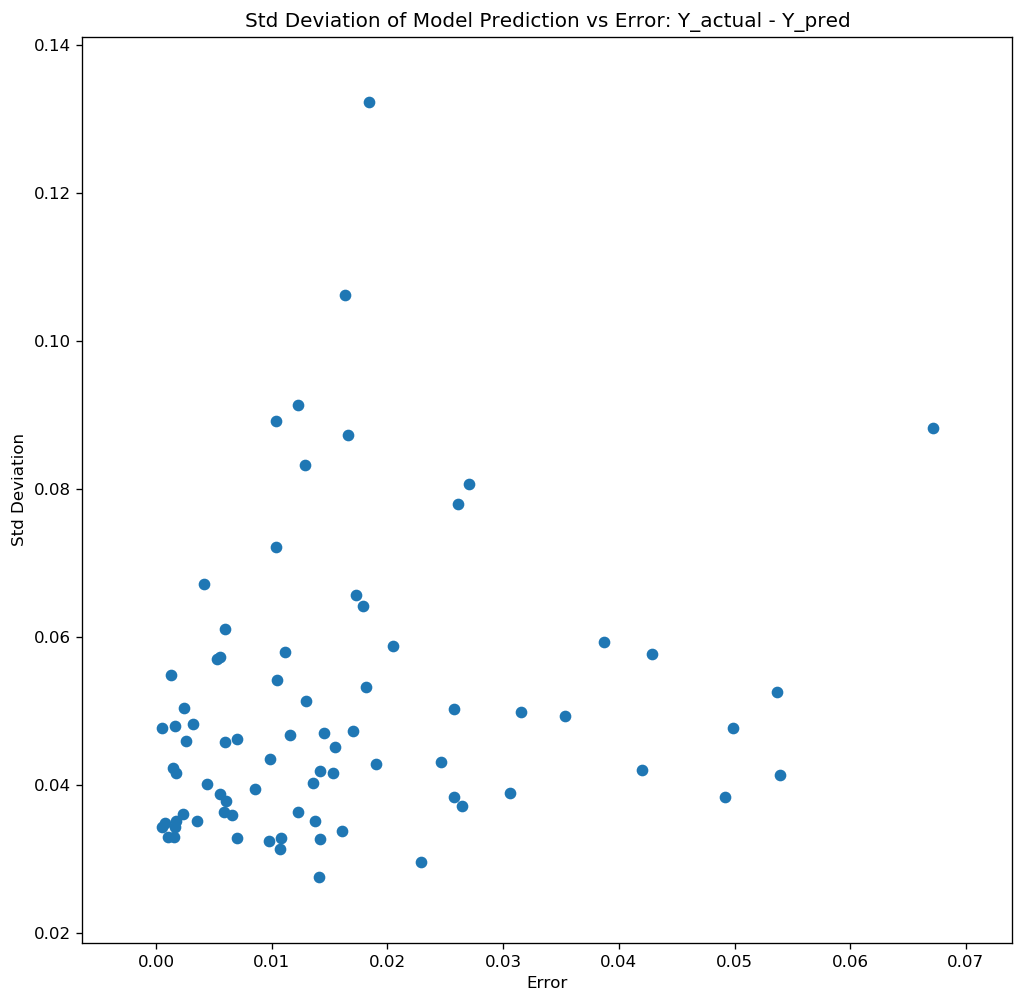

<Figure size 432x288 with 0 Axes>

In [13]:
error_v1 = np.abs(y_actual-y_pred_mean_kfold_np)
y_pred_kfold_std_np_abs = np.abs(y_pred_kfold_std_np)

fig = plt.figure(2,dpi=120,figsize=(10,10))
plt.title("Std Deviation of Model Prediction vs Error: Y_actual - Y_pred")
plt.ylabel("Std Deviation")
plt.xlabel("Error")
plt.scatter(error_v1,y_pred_kfold_std_np_abs)
plt.show()
plt.clf()

In [14]:
y_pred_kfold_std_np_abs

array([0.04308102, 0.04568635, 0.08823584, 0.04001983, 0.04272569,
       0.04693744, 0.03377683, 0.03501637, 0.07785659, 0.03507498,
       0.03506822, 0.05922756, 0.05474922, 0.0531478 , 0.03596777,
       0.07209014, 0.10609494, 0.050349  , 0.04617423, 0.03282135,
       0.04342723, 0.04018636, 0.03878792, 0.05254649, 0.0393663 ,
       0.03485585, 0.03287857, 0.04505732, 0.03781751, 0.03833094,
       0.04721504, 0.03273157, 0.04191206, 0.03269435, 0.03233491,
       0.0328492 , 0.04823929, 0.04125057, 0.04763316, 0.05868385,
       0.03421393, 0.02750749, 0.08057739, 0.04225702, 0.08916312,
       0.03626625, 0.03426296, 0.04153102, 0.03633859, 0.02959074,
       0.05762763, 0.03711998, 0.04670518, 0.03132918, 0.03835474,
       0.04188279, 0.03885705, 0.08318946, 0.04980651, 0.09127091,
       0.05415479, 0.03583572, 0.06412551, 0.05130177, 0.04584788,
       0.04762236, 0.04797892, 0.04922919, 0.06102406, 0.06716661,
       0.05700903, 0.05017402, 0.08728587, 0.13219912, 0.04149